In [59]:
import torch
from torch.utils.data import DataLoader
import os 
import cv2


In [60]:
from torchvision import transforms

def load_images(image_folder):
    images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('_test.jpg'):
            file_id = filename.split('_')[0]
            full_path = os.path.join(image_folder, filename)
            image = cv2.imread(full_path)  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            image_tensor = transforms.ToTensor()(image)  
            images[file_id] = image_tensor
    return images

In [61]:
def parse_annotations(annotation_folders):
    annotations = {}
    for file in os.listdir(annotation_folders):
        if file.endswith('.txt'):
            file_id = os.path.splitext(file)[0]
            file_path = os.path.join(annotation_folders, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                bbox_data = []
                labels = []
                for line in lines:
                    x1, y1, x2, y2, damage_type = map(int, line.split())
                    bbox_data.append([x1, y1, x2, y2]) 
                    labels.append(damage_type) 

                bbox_tensor = torch.tensor(bbox_data, dtype=torch.float32) 
                labels_tensor = torch.tensor(labels, dtype=torch.int64)  
                annotations[file_id] = {'boxes': bbox_tensor, 'labels': labels_tensor}
    return annotations

In [62]:
annotations = parse_annotations("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/group00041/00041_not")
dataset_image  = load_images("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/group00041/00041")
merged_dict = {img_id: (dataset_image[img_id], annotations[img_id]) for img_id in dataset_image if img_id in annotations}

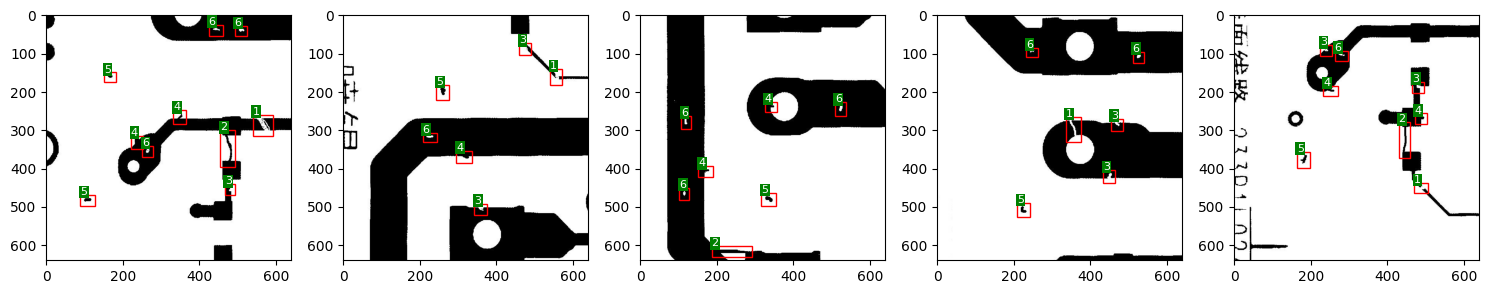

In [63]:
import matplotlib.pyplot as plt
from matplotlib import patches

num_images_to_display = 5

fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i, image_id in enumerate(list(merged_dict.keys())[:num_images_to_display]):
    image_tensor, annotations = merged_dict[image_id]

    boxes = annotations['boxes']
    labels = annotations['labels']
    image_tensor = image_tensor.permute(1, 2, 0)
    image_np = image_tensor.numpy()
    
    ax = axs[i]
    ax.imshow(image_np)
    
    for bbox, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    
    ax.axis('on')

plt.tight_layout()
plt.show()


In [64]:
from torch.utils.data import Dataset

class PCBDefectDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (dict): A dictionary where keys are image IDs and values are tuples,
                         with the first element being the image tensor and the second
                         being the annotation dictionary containing 'boxes' and 'labels'.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.data = data
        self.ids = list(data.keys())  
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image, targets = self.data[img_id] 
        if self.transform:
            image = self.transform(image)  
        return image, targets


In [65]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

def collate_fn(batch):
    images, annotations = zip(*batch)
    return list(images), list(annotations) 

from torch.utils.data import DataLoader, random_split

# Assuming PCBDefectDataset is defined and merged_dict is available
dataset = PCBDefectDataset(merged_dict, transform=None)

# Calculate lengths for splits
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% of dataset
validate_size = int(0.15 * total_size)  # 15% of dataset
test_size = total_size - train_size - validate_size  # Remaining data for testing

# Split the dataset
train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size])

batch_s = 4
# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

# test image 
subset_indices = [0,1]
train_subset = Subset(dataset, subset_indices)
train_loader_single = DataLoader(train_subset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

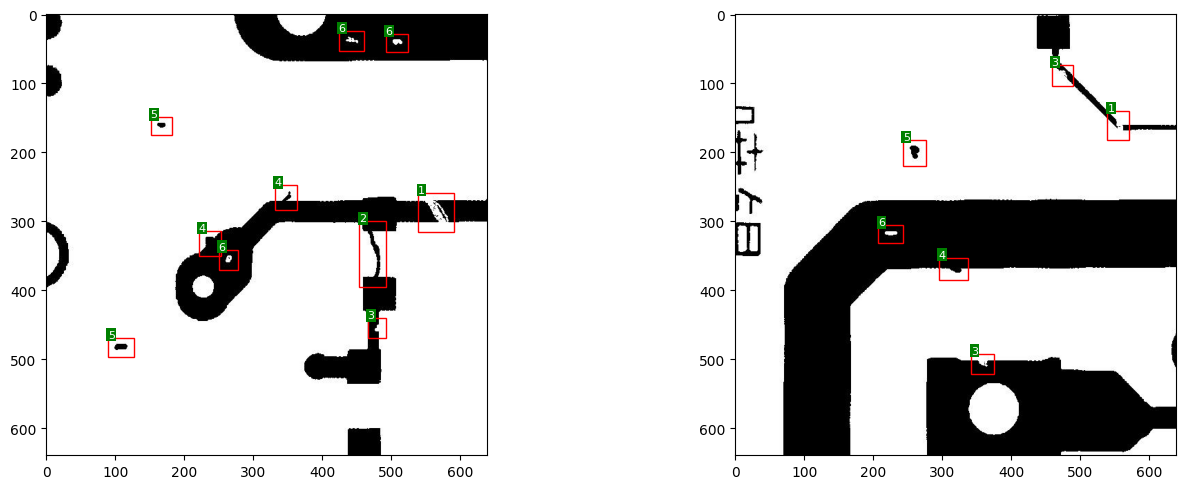

In [66]:
num_images_to_display = 2
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i in range(num_images_to_display):
    image_tensor, annotations = train_subset[i]
    boxes = annotations['boxes']
    gt_labels = annotations['labels']
    image_tensor = image_tensor.permute(1, 2, 0)
    image_np = image_tensor.numpy()    
    ax = axs[i]
    ax.imshow(image_np) 
    for bbox, label in zip(boxes, gt_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    ax.axis('on')
plt.tight_layout()
plt.show()

In [67]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 7  # 6 object classes + 1 background

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [69]:
print(torch.version.cuda)
if torch.cuda.is_available():
    print("CUDA is available. Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")


12.1
CUDA is available. Device name: NVIDIA GeForce RTX 3080 Ti


In [70]:
# from torch.optim import SGD

# train_losses_list = []
# validate_losses_list =[]

# num_epochs = 100
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-6)
# model.to(device)

# img_limit = 10

# for epoch in range(num_epochs):
#     epoch_loss = 0
#     train_loss = 0
#     images_processed = 0
#     img_count = 0
#     for data in train_loader_single:
#         imgs = []
#         targets = []
#         for d in train_subset:
#             if (img_count > img_limit): 
#                 break
#             img_count += 1
#             imgs.append(d[0][0].to(device))
#             print(imgs[0].shape)
#             targ = {}
#             targ["boxes"] = d[1]["boxes"].to(device)
#             targ["labels"] = d[1]["labels"].to(device)
#             targets.append(targ)
#         loss_dict = model(imgs, targets)
#         loss = sum(v for v in loss_dict.values())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         images_processed += len(imgs)

#         avg_train_loss = train_loss / images_processed
#         print(f"Epoch {epoch}: Training Loss: {avg_train_loss}")
#         train_losses_list.append(avg_train_loss)
#     # Validation phase
#     model.eval()
#     epoch_val_loss = 0
#     val_images_processed = 0
#     with torch.no_grad():
#         for data in validate_dataset:
#             imgs = [d[0].to(device) for d in data]
#             targets = [{k: v.to(device) for k, v in d[1].items()} for d in data]
#             loss_dict = model(imgs, targets)
#             loss = sum(v for v in loss_dict.values())
#             epoch_val_loss += loss.item()
#             val_images_processed += len(imgs)

#     avg_val_loss = epoch_val_loss / val_images_processed
#     validate_losses_list.append(avg_val_loss)

#     print(f" Validation Loss: {avg_val_loss}")


In [78]:
from torch.optim import SGD

train_losses_list = []
validate_losses_list =[]
all_outputs = []

num_epochs = 50
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-6)
model.to(device)
n_images = 200

print("num epochs",num_epochs)
print("num images",n_images)
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    images_processed = 0
    for data in train_loader:
        if images_processed >= n_images:
            break
        imgs = data[0]
        targets = data[1]
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_train_loss += losses.item()
        images_processed += len(imgs)
    
    avg_train_loss = epoch_train_loss / len(train_subset.dataset)
    train_losses_list.append(avg_train_loss)
    print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for imgs, targets in validate_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            model.train()
            loss_dict = model(imgs, targets)
            model.eval() 
            
            losses = sum(loss for loss in loss_dict.values())
            epoch_val_loss += losses.item()
            all_outputs.extend(outputs)
    avg_val_loss = epoch_val_loss / len(validate_loader.dataset)
    validate_losses_list.append(avg_val_loss)
    print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")



Epoch 0: Average Training Loss: 0.22145024279124056
Epoch 0: Average Validation Loss: 0.3653354319659146
Epoch 1: Average Training Loss: 0.24298573403336884
Epoch 1: Average Validation Loss: 0.3972819248835246
Epoch 2: Average Training Loss: 0.25779259690332196
Epoch 2: Average Validation Loss: 0.41073501471317175
Epoch 3: Average Training Loss: 0.2626712548786698
Epoch 3: Average Validation Loss: 0.4144395264712247
Epoch 4: Average Training Loss: 0.26302593164314514
Epoch 4: Average Validation Loss: 0.4028748635089759
Epoch 5: Average Training Loss: 0.25910956018111286
Epoch 5: Average Validation Loss: 0.3964035222024629
Epoch 6: Average Training Loss: 0.25497267634620496
Epoch 6: Average Validation Loss: 0.38582011425133905
Epoch 7: Average Training Loss: 0.2464839673150179
Epoch 7: Average Validation Loss: 0.3703116395256736
Epoch 8: Average Training Loss: 0.23835487171535577
Epoch 8: Average Validation Loss: 0.3616097406907515
Epoch 9: Average Training Loss: 0.2292963584623725
Epoc

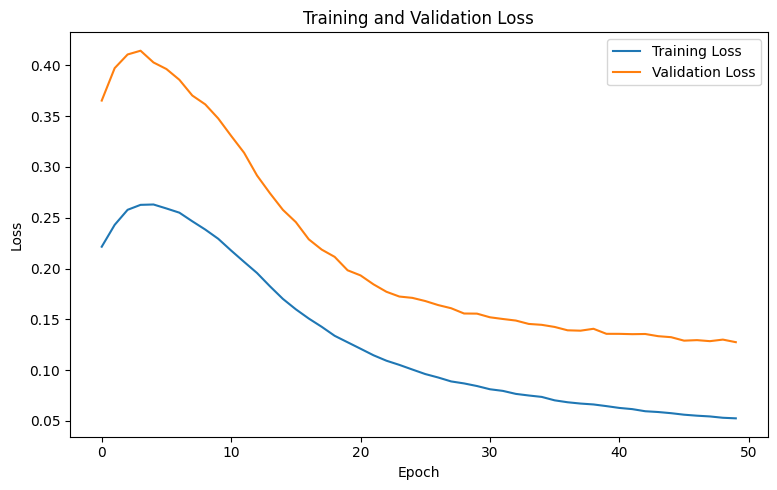

In [79]:
plt.figure(figsize=(15, 5))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_list, label='Training Loss')
plt.plot(validate_losses_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
from torchvision.ops import nms

nms_outputs = []
for output in all_outputs:
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    print("out_bbox",boxes.shape)

    keep = nms(boxes, scores, 0.5)  


    nms_outputs.append({
        'boxes': boxes[keep],
        'labels': labels[keep],
        'scores': scores[keep]
    })
    print("keep",boxes[keep].shape)


out_bbox torch.Size([100, 4])
keep torch.Size([47, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([45, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([47, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([44, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([40, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([34, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([35, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([39, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([47, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([44, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([36, 4])
out_bbox torch.Size([89, 4])
keep torch.Size([43, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([40, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([51, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([44, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([45, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([36, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([52, 4])
out_bbox to

keep torch.Size([25, 4])
out_bbox torch.Size([75, 4])
keep torch.Size([24, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([33, 4])
out_bbox torch.Size([94, 4])
keep torch.Size([31, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([34, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([33, 4])
out_bbox torch.Size([76, 4])
keep torch.Size([26, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([38, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([40, 4])
out_bbox torch.Size([74, 4])
keep torch.Size([36, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([42, 4])
out_bbox torch.Size([77, 4])
keep torch.Size([23, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([43, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([37, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([31, 4])
out_bbox torch.Size([60, 4])
keep torch.Size([21, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([36, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([38, 4])
out_bbox torch.Size([100, 4])
keep torch.Size(

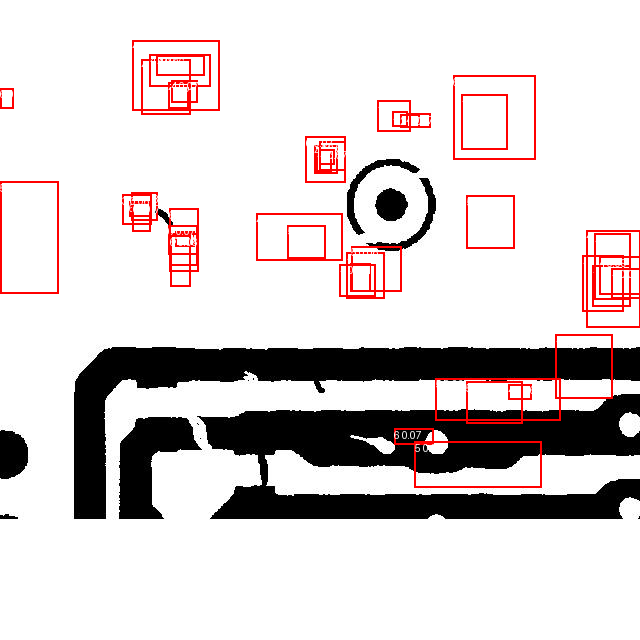

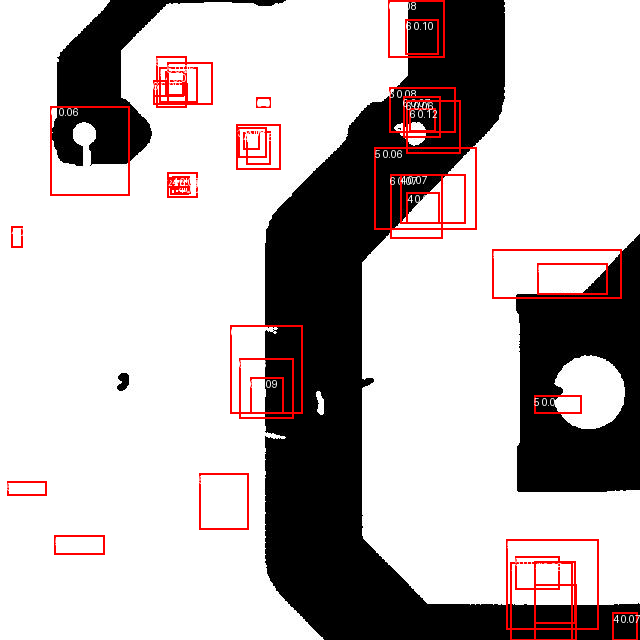

IndexError: list index out of range

In [86]:
from PIL import Image, ImageDraw

for i in range(4): 
    output = nms_outputs[i]
    boxes = output['boxes']
    labels = output['labels']
    scores = output['scores']  

    img_tensor = data[0][i]  
    img_pil = Image.fromarray(img_tensor.cpu().mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(img_pil)
    
    for box, label, score in zip(boxes, labels, scores):
        box = box.cpu().numpy() 
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=2)
        draw.text((box[0], box[1]), f'{label} {score:.2f}', fill='white')

    display(img_pil)
